# CS 445: Computational Photography Final Project

## Algorithmic Basketball Detection via Segmentation
Inspired by (insert original paper link here)

TODO: 
- Find frames that work with our detection function from said new videos 
- Find unsuccessful frames to show the challenges of our method (when basketball is in players' hand, if there is not a lot of motion from frame to frame, false positive detection of faces, etc.)

### Frame Extraction

In [3]:
import cv2
import numpy as np
from pathlib import Path
import os

In [4]:
def extract_frames(video_path, output_dir, frames_per_second=60):
    """
    Extract frames from video at specified temporal rate

    Args:
        video_path: Path to input video
        output_dir: Directory to save frames
        frames_per_second: Number of frames to extract per second of video, should be geq the video's frame rate
    """
    Path(output_dir).mkdir(exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")

    # get video properties and calc sample rate
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    sample_rate = int(fps / frames_per_second)

    frame_count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # save frame at the rate specified 
        if frame_count % sample_rate == 0:
            output_path = os.path.join(output_dir, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(output_path, frame)
            saved_count += 1

            # print progress
            if saved_count % 10 == 0:
                print(f"Saved {saved_count} frames...")

        frame_count += 1

    cap.release()
    print(f"Extraction complete. Processed {frame_count} frames, saved {saved_count} frames")

In [ ]:
video_path = "data/basketball-free-throws-urichmond.mp4"
output_dir = "data/basketball-free-throws-urichmond-frames/"
extract_frames(video_path, output_dir, frames_per_second=20)

In [ ]:
video_path = "data/Suns-Warriors-11-30-24-KD3Pt.mp4"
output_dir = "data/Suns-Warriors-11-30-24-KD3Pt-frames/"
extract_frames(video_path, output_dir, frames_per_second=30)

In [ ]:
video_path = "../data/GuangdongBeijing12122024_1.mp4"
output_dir = "../data/GuangdongBeijing_1-frames"
extract_frames(video_path, output_dir, frames_per_second=24)

### Ball Detection

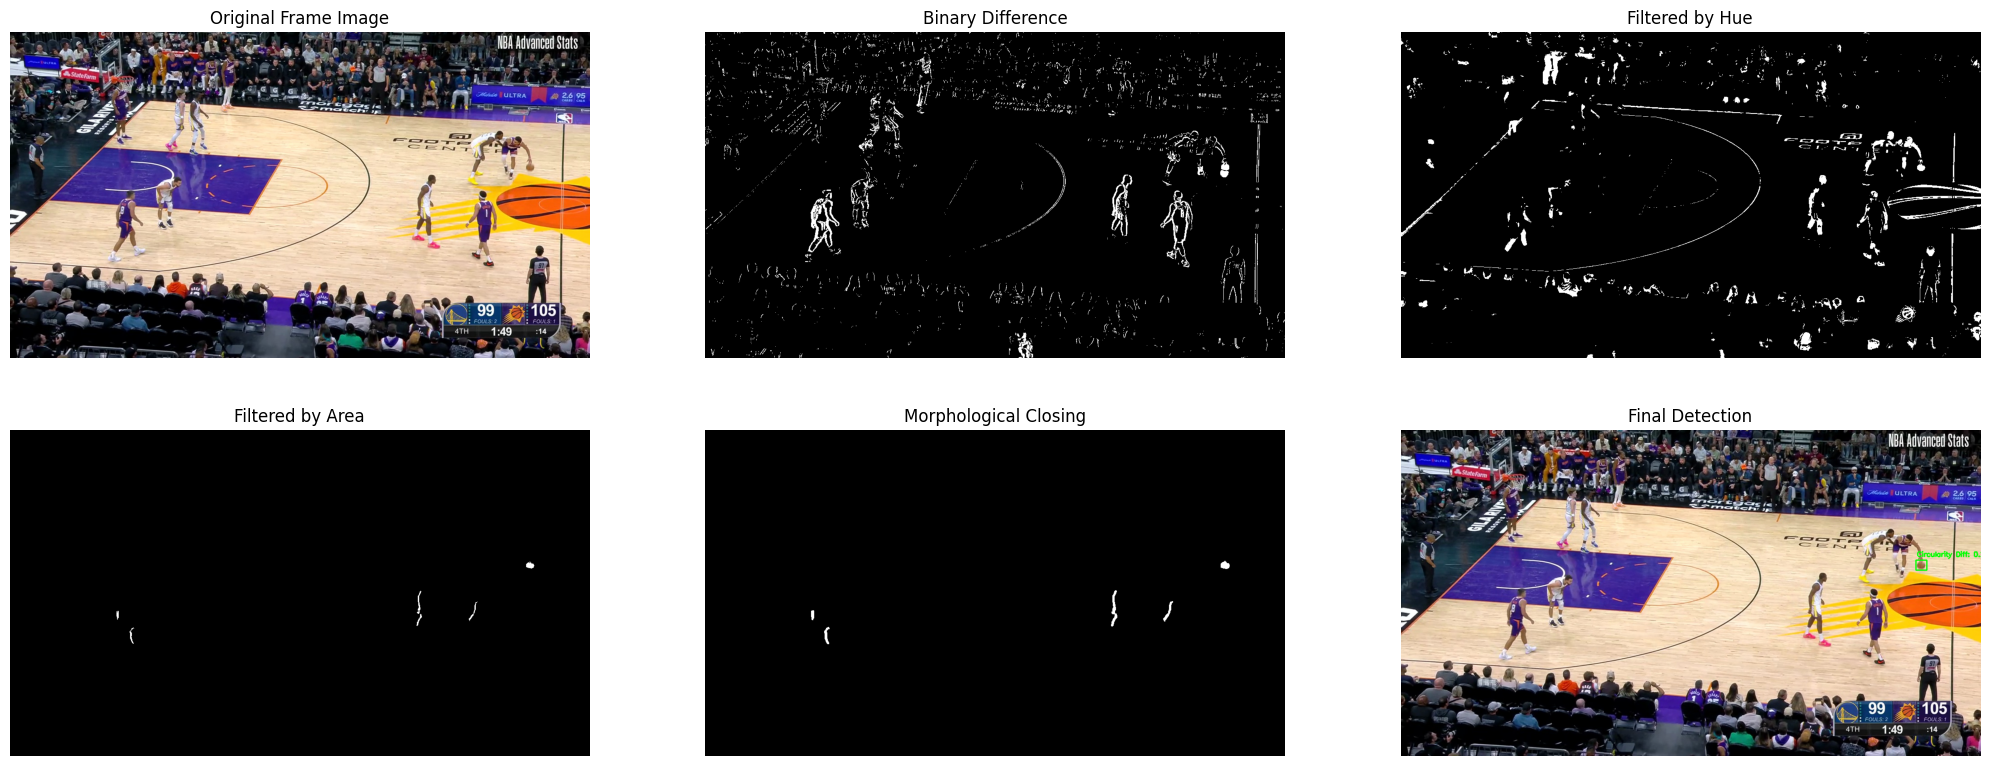

In [32]:
import matplotlib.pyplot as plt

def detect_basketball_with_visualization(frame1, frame2, min_area=50, circularity_threshold=0.3, visualize=False, intermediate_file=None):
    """
    Detects basketball in a frame using a combination of filtering and morphological operations

    Args:
        frame1: frame we want to detect and visualize the detection on
        frame2: immediate subsequent frame after frame1, used for motion detection and binary diff
        min_area: minimum area of connected component to keep in the binary diff mask
        circularity_threshold (optional): threshold for circularity difference to keep a contour
        visualize: whether to visualize intermediate steps
        intermediate_file: file to save the intermediate visualization to     
    """
    # create binary difference image between frame1 and frame2
    diff = cv2.absdiff(frame1, frame2)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, binary_diff = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)

    # filter by HSV color (H values up to 60 as the paper section 2.3 suggests)
    hsv = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)
    brown_mask = cv2.inRange(hsv, (0, 100, 20), (60, 255, 200))

    # combine with color mask
    combined_mask = cv2.bitwise_and(binary_diff, brown_mask)

    # filter by area, min_area is parameterized since the ball may be larger or smaller based on camera angle (default 50px)
    area_filtered_mask = np.zeros_like(combined_mask)

    # find connected components (contours) of the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # if the component is large enough, keep it
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            cv2.drawContours(area_filtered_mask, [contour], -1, 255, -1)

    # use morphological closing to fill gaps in close-to-circle object (our innovation since we noticed struggled without it)
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask = cv2.dilate(area_filtered_mask, kernel)
    closed_mask = cv2.morphologyEx(dilated_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = closed_mask

    # filter by circularity, circularity_diff closer to 0 means closer to a perfect circle
    circularity_filtered_mask = np.zeros_like(combined_mask)
    best_candidate = None
    best_circularity_diff = float('inf')

    # recompute contours after morphological closing
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = (4 * np.pi * area) / (perimeter ** 2)
        circularity_diff = abs(circularity - 1)

        if circularity_diff <= circularity_threshold:  # parameterized threshold for how good the circle should be
            # only keep close to circle for visualizing the best candidates
            cv2.drawContours(circularity_filtered_mask, [contour], -1, 255, -1)
            if circularity_diff < best_circularity_diff:
                best_circularity_diff = circularity_diff
                best_candidate = contour

    # final detection result on top of frame1
    result = frame1.copy()
    if best_candidate is not None:
        x, y, w, h = cv2.boundingRect(best_candidate)
        padding = 2
        cv2.rectangle(result,
                     (max(0, x - padding), max(0, y - padding)),
                     (min(result.shape[1], x + w + padding),
                      min(result.shape[0], y + h + padding)),
                     (0, 255, 0), 2)
        # also print the circularity difference under the detection
        cv2.putText(result, f"Circularity Diff: {best_circularity_diff:.2f}",
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # if we want to visualize the intermediate steps, display in a grid sequentially
    if visualize:
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
        ax[0, 0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
        ax[0, 0].set_title('Original Frame Image')
        ax[0, 0].axis('off')

        ax[0, 1].imshow(binary_diff, cmap='gray')
        ax[0, 1].set_title('Binary Difference')
        ax[0, 1].axis('off')

        ax[0, 2].imshow(brown_mask, cmap='gray')
        ax[0, 2].set_title('Filtered by Hue')
        ax[0, 2].axis('off')

        ax[1, 0].imshow(area_filtered_mask, cmap='gray')
        ax[1, 0].set_title('Filtered by Area')
        ax[1, 0].axis('off')

        ax[1, 1].imshow(combined_mask, cmap='gray')
        ax[1, 1].set_title('Morphological Closing')
        ax[1, 1].axis('off')

        ax[1, 2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        ax[1, 2].set_title('Final Detection')
        ax[1, 2].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(wspace=0.2, hspace=0.1)
        plt.savefig(intermediate_file)
        plt.show()

    return result

# example usage with an NBA clip (successful)
frame1_path = "../data/Suns-Warriors-11-30-24-KD3Pt-frames/frame_0012.jpg"
frame1 = cv2.imread(frame1_path)
frame2_path = "../data/Suns-Warriors-11-30-24-KD3Pt-frames/frame_0013.jpg"
frame2 = cv2.imread(frame2_path)
intermediate_file = "../results/intermediate/KD3Pt-Frame12.jpg"

result = detect_basketball_with_visualization(frame1, frame2, visualize=True, min_area=50, intermediate_file=intermediate_file)

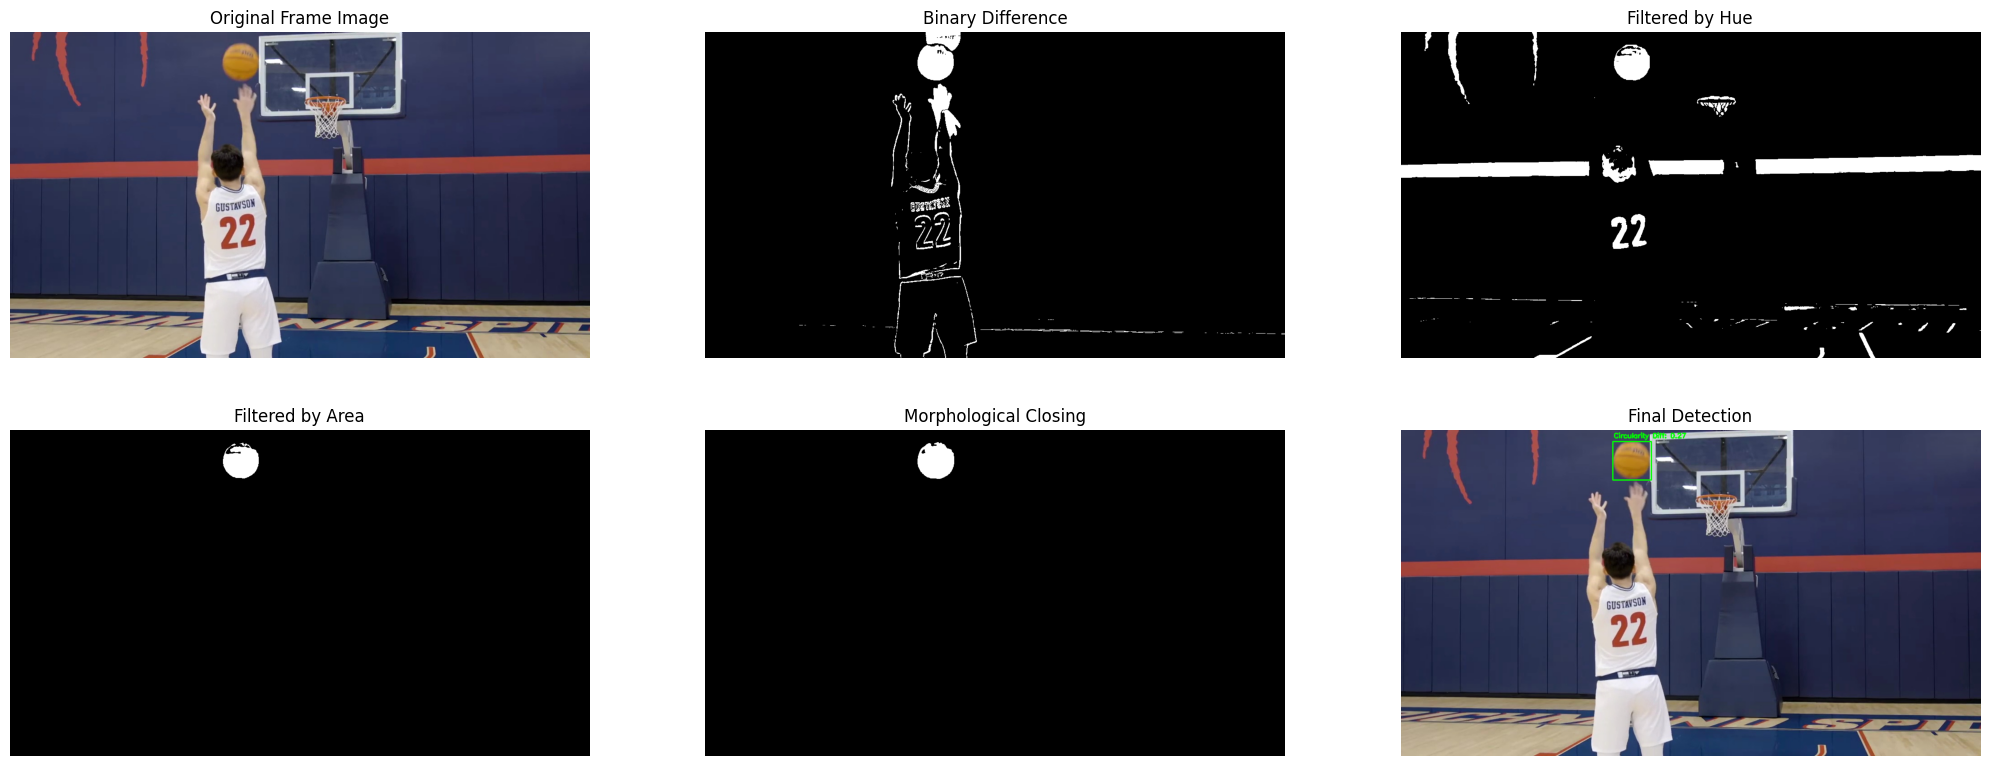

In [ ]:
# example usage with the simple free throw clip (successful)
frame1_ft_path = "../data/basketball-free-throws-urichmond-frames/frame_0036.jpg"
frame1_ft = cv2.imread(frame1_ft_path)
frame2_ft_path = "../data/basketball-free-throws-urichmond-frames/frame_0037.jpg"
frame2_ft = cv2.imread(frame2_ft_path)
intermediate_file = "../results/intermediate/FreeThrow-Frame36.jpg"

result_ft = detect_basketball_with_visualization(frame1_ft, frame2_ft, min_area=200, visualize=True, intermediate_file=intermediate_file)

In [4]:
# TODO: save more intermediate and final detection results for each of the clips
# ideally at least three success and three failure frames from each person

### Frame Processing and Video Stitching

In [38]:
def process_frames_to_video(frames_dir, output_dir, output_name, fps, circularity_threshold=0.3):
    """
    Perform basketball detection on a full set of frames in a directory and save to a video

    Args:
        frames_dir: directory containing frames extracted via extract_frames
        output_dir: directory to save output video
        output_name: name of output video file
        fps: frames per second of output video, should match fps used in extract_frames
        circularity_threshold (optional): threshold for circularity difference to keep a contour
    """
    # get list of frame paths
    frame_paths = sorted(Path(frames_dir).glob('*.jpg'))
    if len(frame_paths) == 0:
        raise ValueError(f"No frames found in directory: {frames_dir}")

    # load first frame to get dimensions
    frame = cv2.imread(str(frame_paths[0]))
    height, width, _ = frame.shape

    # initialize video writer (MP4 codec)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = os.path.join(output_dir, output_name)
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i in range(len(frame_paths) - 1):  # -1 because we need pairs of frames for the function to work
        frame1 = cv2.imread(str(frame_paths[i]))
        frame2 = cv2.imread(str(frame_paths[i + 1]))
        result = detect_basketball_with_visualization(frame1, frame2, circularity_threshold=circularity_threshold)
        out.write(result)

    out.release()
    print(f"Video saved to: {output_path}")

In [39]:
# working example on the urichmond free throw clip
ft_frames_dir = "../data/basketball-free-throws-urichmond-frames/"
output_dir = "../results"
output_name = "free_throws_urichmond_detection.mp4"
process_frames_to_video(ft_frames_dir, output_dir, output_name, fps=20)

Video saved to: ../results/free_throws_urichmond_detection.mp4


In [43]:
# working example on the NBA clip (unsuccessful because of false positives and overlapping contour with player/ball)
ft_frames_dir = "../data/Suns-Warriors-11-30-24-KD3Pt-frames"
output_dir = "../results/"
output_name = "suns_warriors_KD3Pt_detection.mp4"
process_frames_to_video(ft_frames_dir, output_dir, output_name, fps=30)

Video saved to: ../results/suns_warriors_KD3Pt_detection.mp4


In [42]:
# example on Gunagdong vs beijing 12/12/2024, could experiment with lower circularity threshold
ft_frames_dir = "../data/GuangdongBeijing_1-frames"
output_dir = "../results/"
output_name = "GuangdongBeijing_1_detection.mp4"
process_frames_to_video(ft_frames_dir, output_dir, output_name, fps=24)

Video saved to: ../results/GuangdongBeijing_1_detection.mp4


In [ ]:
# TODO: also the example from Curry / Kerr free throw